# Selección de características con SFS

### Parte 1

In [1]:
import numpy as np
from sklearn.neighbors import KNeighborsClassifier
import scipy.io

In [2]:
data = scipy.io.loadmat('DATOS1.mat')

In [3]:
Xtest = data['Xtest']
Ytest = data['Ytest']
Xtrain = data['Xtrain']
Ytrain = data['Ytrain']

In [4]:
neighbors = KNeighborsClassifier(n_neighbors=1)

In [5]:
neighbors.fit(Xtrain, Ytrain.flatten())

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=1, p=2,
           weights='uniform')

In [6]:
Ypred = neighbors.predict(Xtest)

In [7]:
correct = (Ypred == Ytest.flatten()).astype(int).sum()

In [8]:
accuracy = correct / Ytest.size * 100

In [9]:
accuracy

91.86046511627907

### Parte 2

In [10]:
from pybalu.feature_selection import sfs

In [11]:
datos2 = scipy.io.loadmat('DATOS2.mat')
X = datos2['X']
Y = datos2['Y']

In [12]:
N_FEATURES = 15

In [13]:
selected_feats = sfs(X, Y, n_features=N_FEATURES, method="fisher", show=True)

Selecting Features: 100%|██████████| 15.0/15.0 [00:01<00:00, 10.0 features/s]


In [14]:
selected_feats

array([225, 298, 295, 296, 294, 297,  88, 277,  97,  67, 279, 201,  83,
       227, 230])

In [15]:
Xtrain_new = Xtrain[:, selected_feats]
Xtest_new = Xtest[:, selected_feats]

In [16]:
neighbors_new = KNeighborsClassifier(n_neighbors=1)
neighbors_new.fit(Xtrain_new, Ytrain.flatten())

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=1, p=2,
           weights='uniform')

In [17]:
Ypred_new = neighbors_new.predict(Xtest_new)

In [18]:
correct = (Ypred_new == Ytest.flatten()).astype(int).sum()
accuracy = correct / Ytest.size * 100
accuracy

95.34883720930233

# Extracción de características geométricas con Balu

In [19]:
import matplotlib.pyplot as plt
from pybalu.feature_extraction import fourier_des_features, hugeo_features, flusser_features
from pybalu.io import imread
from pybalu.io import print_features
from os import listdir

In [20]:
arrows_training_names = [i for i in listdir('arrows_training') if i.endswith('png')]
arrows_testing_names = [i for i in listdir('arrows_testing') if i.endswith('png')]

In [21]:
arrows_training = [imread(f'arrows_training/{i}') for i in arrows_training_names]
arrows_testing = [imread(f'arrows_testing/{i}') for i in arrows_testing_names]

In [22]:
y_training = np.array([int(i[5:7]) for i in arrows_training_names])
y_testing = np.array([int(i[5:7]) for i in arrows_testing_names])

Cargamos las imagenes en los arrows_testing y arrows_training con su respectivo nombre, y pasamos el label entero de forma que 1 es unidireccional curva, y así.

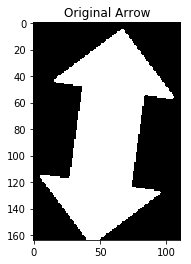

In [23]:
# example showing image
plt.title("Original Arrow")
plt.imshow(arrows_training[0], cmap="gray")
plt.show()

In [24]:
# example geo extraction
im_bin = (arrows_training[0] > 140).astype(int)
labels, features = fourier_des_features(im_bin, labels=True)
print_features(labels, features)

Fourier-des  1:  0.01245
Fourier-des  2:  0.97540
Fourier-des  3:  0.01619
Fourier-des  4:  0.36507
Fourier-des  5:  0.01059
Fourier-des  6:  0.00718
Fourier-des  7:  0.03498
Fourier-des  8:  0.68532
Fourier-des  9:  0.02455
Fourier-des 10:  0.07124
Fourier-des 11:  0.00605
Fourier-des 12:  0.24709
Fourier-des 13:  0.04633
Fourier-des 14:  0.32950
Fourier-des 15:  0.01488
Fourier-des 16:  0.12151


Creamos ahora nuestra función para extraer todas las características, que son las geométricas, los momentos de Hu, los momentos de Flusser y los concatenamos en un solo vector para cada imagen

In [25]:
def feature_extraction(im_bin):
    descriptors = fourier_des_features(im_bin)
    hu = hugeo_features(im_bin)
    flusser = flusser_features(im_bin)
    return np.hstack((descriptors, hu, flusser))

Ejecutamos esta función para cada imagen de entrenamiento luego de binarizarla, y aplicamos el mismo procedimiento para el set de training y de testing

In [26]:
binarized_arrows_training = [(i > 140).astype(int) for i in arrows_training]
arrows_training_features = np.array([feature_extraction(i) for i in binarized_arrows_training])

In [27]:
binarized_arrows_testing = [(i > 140).astype(int) for i in arrows_testing]
arrows_testing_features = np.array([feature_extraction(i) for i in binarized_arrows_testing])

Seleccionamos las mejores features con SFS (probamos con muchas opciones 1, 2, 3, 5, 10, 20 y 27) y resultó ser que con bajo 5 daba peor rendimiento pero en 5 ya daba 100% y de ahí en más no era necesario seguir.

In [28]:
N_FEATURES = 5
selected_feats = sfs(arrows_training_features, y_training, n_features=N_FEATURES, method="fisher", show=True)

Selecting Features: 100%|██████████| 5.00/5.00 [00:00<00:00, 96.2 features/s]


In [29]:
arrows_training_features_new = arrows_training_features[:, selected_feats]
arrows_testing_features_new = arrows_testing_features[:, selected_feats]

Utilizamos un clasificador de KNN

In [30]:
neighbors_arrows = KNeighborsClassifier(n_neighbors=1)
neighbors_arrows.fit(arrows_training_features_new, y_training)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=1, p=2,
           weights='uniform')

In [31]:
Ypred_arrows_new = neighbors_arrows.predict(arrows_testing_features_new)

In [32]:
correct = (Ypred_arrows_new == y_testing).astype(int).sum()
accuracy = correct / y_testing.size * 100
accuracy

100.0

Dado la naturaleza de los datos, y lo simple del experimento, se ve que son necesarias pocas features para obtener un 100%. Es importante notar que esto se debe a lo acotado del problema y no a que nuestro algoritmo sea perfecto, dado que probablemente con otras instancias de testing ya no sea tan robusto.